## Loading files

### Setup

In [29]:
!pip install pyconll

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!curl https://raw.githubusercontent.com/UniversalDependencies/UD_Ancient_Greek-Perseus/master/grc_perseus-ud-train.conllu -o data/perseus-conllu/grc_perseus-ud-train.conllu
!curl https://raw.githubusercontent.com/UniversalDependencies/UD_Ancient_Greek-Perseus/raw/master/grc_perseus-ud-dev.conllu -o data/perseus-conllu/grc_perseus-ud-dev.conllu
!curl https://github.com/UniversalDependencies/UD_Ancient_Greek-Perseus/raw/master/grc_perseus-ud-test.conllu -o data/perseus-conllu/grc_perseus-ud-test.conllu

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    683      0 --:--:-- --:--:-- --:--:--   683
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   179  100   179    0     0    304      0 --:--:-- --:--:-- --:--:--   304
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   180  100   180    0     0    357      0 --:--:-- --:--:-- --:--:--   356


### Parsing

In [30]:
import pyconll

In [74]:
# NOTE: this is actually the validation set, not the training set
train = pyconll.load_from_file('data/perseus-conllu/grc_perseus-ud-dev.conllu')

train_data = []

for sentence in train:
    sentence_words = []
    sentence_tags = []
    for token in sentence:
        sentence_words.append(token.form)
        sentence_tags.append(token.upos)
    
    if len(sentence_words) > 0:
        train_data.append((sentence_words, sentence_tags))

In [51]:
word_to_ix = {}
for words, tags in train_data:
    for word in words:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
len(word_to_ix)

6899

In [52]:
tag_to_ix = {}
for sent, tags in train_data:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

len(tag_to_ix)

13

## Model setup

Based on https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from model.lstm import LSTMTagger

In [77]:
torch.manual_seed(1)

EMBEDDING_DIM = 100
HIDDEN_DIM = 20

In [78]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [79]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

## Model training

In [100]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [102]:
# TODO: implement batches
# TODO: evaluate loss on separate validation dataset

losses = []

for epoch in range(5):
    total_loss = 0

    for sentence, tags in train_data:
        model.zero_grad()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss

    print('Epoch %d: %.4f' % (epoch, total_loss / len(train_data)))
    losses.append(total_loss / len(train_data))

Epoch 0: 0.0928
Epoch 1: 0.0874
Epoch 2: 0.0825
Epoch 3: 0.0780
Epoch 4: 0.0739


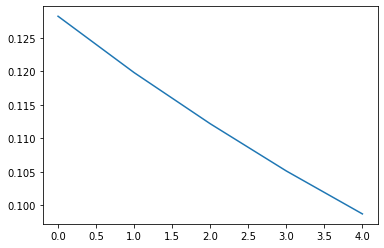

In [101]:
plt.figure()
plt.plot(losses)

## Inference

In [89]:
sentence = ''
with torch.no_grad():
    inputs = prepare_sequence(train_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)